# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [32]:
from google.colab import drive
drive.mount('/content/drive')

import os
BASE_PATH = "/content/drive/MyDrive/capuchin_project"
os.chdir(BASE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
os.listdir("data")

['Parsed_Not_Capuchinbird_Clips',
 'Forest Recordings',
 'Parsed_Capuchinbird_Clips']

In [34]:
os.listdir("data/Parsed_Capuchinbird_Clips")[:5]

['XC114131-0.wav',
 'XC114131-1.wav',
 'XC114131-2.wav',
 'XC114131-3.wav',
 'XC114131-4.wav']

In [35]:
os.listdir("data/Parsed_Not_Capuchinbird_Clips")[:5]

['Crickets-chirping-10.wav',
 'Crickets-chirping-1.wav',
 'Crickets-chirping-0.wav',
 'Crickets-chirping-4.wav',
 'Crickets-chirping-2.wav']

In [36]:
os.listdir("data/Forest Recordings")[:5]

['recording_00.mp3',
 'recording_01.mp3',
 'recording_02.mp3',
 'recording_03.mp3',
 'recording_04.mp3']

In [84]:
!pip install tensorflow matplotlib scipy librosa

## 1.2 Load Dependencies

In [38]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import scipy.signal

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [39]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [40]:
def load_wav_16k_mono(filename):
    audio = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)

    def _scipy_resample_fn(audio_data, original_sample_rate, target_sample_rate):
        original_sample_rate = original_sample_rate.numpy().item()
        target_sample_rate = target_sample_rate.numpy().item()
        num_samples_target = int(len(audio_data) * target_sample_rate / original_sample_rate)
        resampled_audio = scipy.signal.resample(audio_data, num_samples_target)
        return resampled_audio.astype('float32')

    current_sample_rate = tf.cast(sample_rate, dtype=tf.float32)
    target_sample_rate = tf.constant(16000.0, dtype=tf.float32)

    resampled_wav = tf.py_function(
        _scipy_resample_fn,
        inp=[wav, current_sample_rate, target_sample_rate],
        Tout=tf.float32
    )
    resampled_wav.set_shape([None])
    return resampled_wav

## 2.3 Plot Wave

In [41]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
print(wave.shape)
print(nwave.shape)

(48000,)
(48927,)


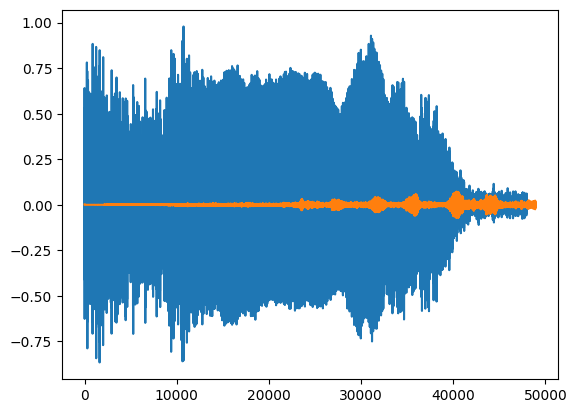

In [42]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [43]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## 3.2 Create Tensorflow Datasets

In [44]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')
print("Positive:", len(list(pos)))
print("Negative:", len(list(neg)))

Positive: 217
Negative: 593


## 3.3 Add labels and Combine Positive and Negative Samples

In [45]:
positives = pos.map(lambda x: (x, 1))
negatives = neg.map(lambda x: (x, 0))
data = positives.concatenate(negatives)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [46]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [47]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [48]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [49]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [50]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [51]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [52]:
spectrogram, label = preprocess(filepath, label)

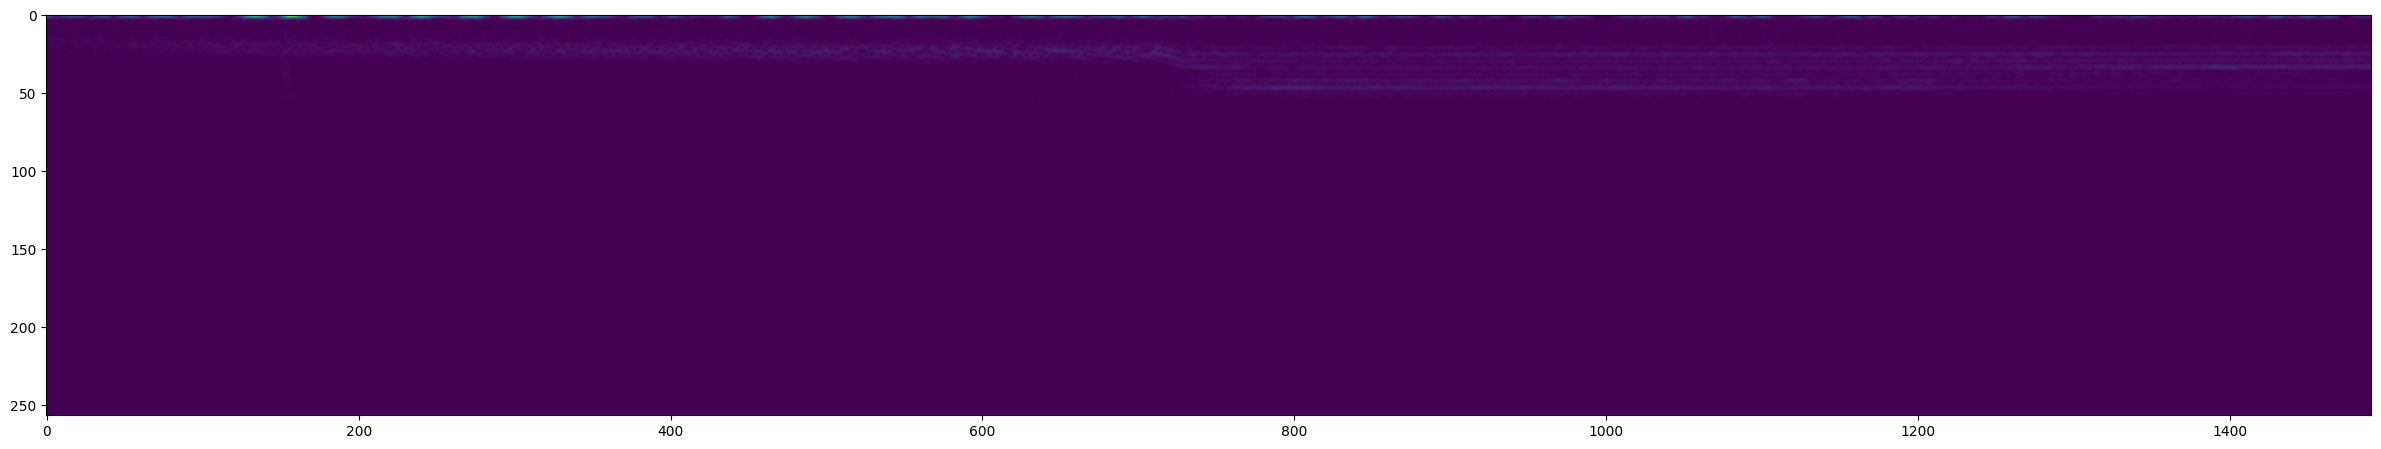

In [53]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [54]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [55]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [56]:
samples, labels = train.as_numpy_iterator().next()

In [57]:
samples.shape

(16, 1491, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D


## 7.2 Build Sequential Model, Compile and View Summary

In [59]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=samples.shape[1:]),
    MaxPooling2D(),

    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [60]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [61]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 1489, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 744, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 742, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 371, 62, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,785 (18.69 KB)

 Trainable params: 4,785 (18.69 KB)

 Non-trainable params: 0 (0.00 B)

## 7.3 Fit Model, View Loss and KPI Plots

In [63]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 191s 5s/step - loss: 0.6806 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.6083 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - loss: 0.5675 - precision_1: 0.4324 - recall_1: 0.0318 - val_loss: 0.4556 - val_precision_1: 0.9412 - val_recall_1: 0.2712
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 221s 6s/step - loss: 0.4930 - precision_1: 0.8743 - recall_1: 0.3632 - val_loss: 0.4350 - val_precision_1: 1.0000 - val_recall_1: 0.4559
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 220s 6s/step - loss: 0.4842 - precision_1: 0.7867 - recall_1: 0.3831 - val_loss: 0.3807 - val_precision_1: 0.8684 - val_recall_1: 0.5690


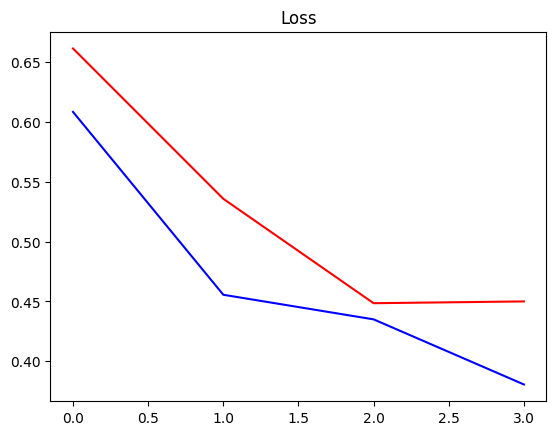

In [65]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

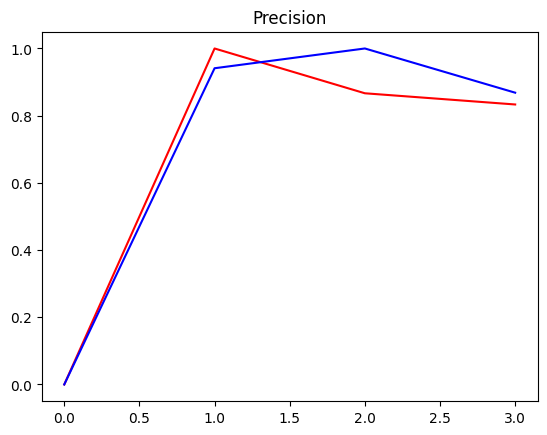

In [67]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

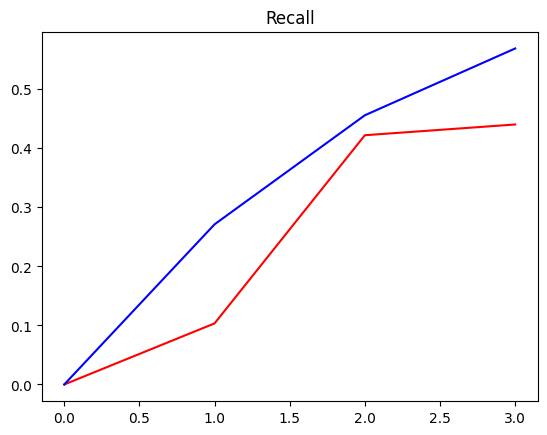

In [69]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [70]:
X_test, y_test = test.as_numpy_iterator().next()

In [71]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


## 8.2 Convert Logits to Classes

In [72]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [85]:
import librosa

def load_mp3_16k_mono(filename):
    audio_data, sample_rate = librosa.load(filename, sr=16000, mono=True)
    wav = tf.convert_to_tensor(audio_data, dtype=tf.float32)
    return wav

In [79]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [86]:
wav = load_mp3_16k_mono(mp3)

In [91]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [92]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [88]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [89]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [90]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step


## 9.4 Group Consecutive Detections

In [93]:
from itertools import groupby

In [94]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [95]:
calls

np.int32(0)

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [96]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━

In [97]:
results

{'recording_00.mp3': array([[0.0972586 ],
        [0.10389598],
        [0.10613377],
        [0.1724682 ],
        [0.8316515 ],
        [0.1394898 ],
        [0.10766748],
        [0.10481982],
        [0.10785361],
        [0.09911884],
        [0.10242797],
        [0.10422022],
        [0.10436254],
        [0.2617502 ],
        [0.8177428 ],
        [0.1071289 ],
        [0.12598829],
        [0.10321131],
        [0.09924836],
        [0.102279  ],
        [0.10248285],
        [0.10307661],
        [0.09985092],
        [0.14443894],
        [0.83051   ],
        [0.14940995],
        [0.1112046 ],
        [0.10086586],
        [0.10910879],
        [0.10354088],
        [0.10155524],
        [0.10082837],
        [0.1192054 ],
        [0.11931005],
        [0.0982347 ],
        [0.12967034],
        [0.8204769 ],
        [0.17317739],
        [0.10492317],
        [0.09899502],
        [0.10360312],
        [0.10714634],
        [0.10389345],
        [0.10796878],
        [0.1

## 10.2 Convert Predictions into Classes

In [98]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [99]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': np.int32(0),
 'recording_01.mp3': np.int32(0),
 'recording_02.mp3': np.int32(0),
 'recording_03.mp3': np.int32(0),
 'recording_04.mp3': np.int32(0),
 'recording_05.mp3': np.int32(0),
 'recording_06.mp3': np.int32(0),
 'recording_07.mp3': np.int32(0),
 'recording_08.mp3': np.int32(0),
 'recording_09.mp3': np.int32(0),
 'recording_10.mp3': np.int32(0),
 'recording_11.mp3': np.int32(1),
 'recording_12.mp3': np.int32(1),
 'recording_14.mp3': np.int32(0),
 'recording_13.mp3': np.int32(0),
 'recording_15.mp3': np.int32(0),
 'recording_16.mp3': np.int32(0),
 'recording_17.mp3': np.int32(0),
 'recording_19.mp3': np.int32(0),
 'recording_18.mp3': np.int32(0),
 'recording_20.mp3': np.int32(0),
 'recording_21.mp3': np.int32(0),
 'recording_22.mp3': np.int32(0),
 'recording_23.mp3': np.int32(0),
 'recording_25.mp3': np.int32(0),
 'recording_27.mp3': np.int32(0),
 'recording_24.mp3': np.int32(0),
 'recording_26.mp3': np.int32(0),
 'recording_29.mp3': np.int32(0),
 'recording_28

# 11. Export Results

In [100]:
import csv

In [102]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])